In [1]:
%matplotlib notebook
import networkx as nx
import itertools
import random
import pandas as pd
from matplotlib import pyplot as plt
from graph_tool.all import load_graph, shortest_distance
from ic import get_gvs, get_o2src_time, simulate_cascade, observe_cascade, sll_using_pairs, gen_nontrivial_cascade, MAXINT
from utils import get_rank_index
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
gtype = 'balanced-tree'
param = '2-6'
g = load_graph('data/{}/{}/graph.gt'.format(gtype, param))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})

In [3]:
p, q = 0.2, 1.0

In [4]:
gvs = get_gvs(g, p, 100)

In [5]:
c, source, obs_nodes = gen_nontrivial_cascade(g, p, q)


In [ ]:
from matplotlib import pyplot as plt
from plot_utils import plot_snapshot
from utils import infeciton_time2weight
from networkx.drawing.nx_agraph import graphviz_layout
pos = graphviz_layout(gnx, root=0)


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
obs_nodes = list(obs_nodes)
plot_snapshot(gnx, pos,
              infeciton_time2weight({i: float(v) for i, v in enumerate(c)}),
              queried_nodes=obs_nodes,
              source_node=source,
              ax=ax,
              max_node_size=500,
              with_labels=True)


In [6]:
o2src_time = get_o2src_time(obs_nodes, gvs)
r = sll_using_pairs(g,
                    obs_nodes,
                    infection_times=c,
                    o2src_time=o2src_time,
                    source=source,
                    method='dist', precond_method='and',
                    return_cascade=True,
                    debug=True)


0it [00:00, ?it/s]/home/cloud-user/code/source_finding/ic.py:521: RuntimeWarning: invalid value encountered in true_divide
  / counts)
10it [00:00, 248.61it/s]

actual_diff: 1
diff means: nan
dist normalization: [ 7  5  9  5  5 11 11  7  5  5  7 13 13 13 13  9  9  7  7  7  5  9  9 15 15
 15 15 15 15 15 15 11 11 11 11  9  9  9  9  9  9  7  7 11 11 11 11 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17]
actual_diff: 1
diff means: nan
dist normalization: [ 7  5  9  7  3 11 11  9  9  1  5 13 13 13 13 11 11 11 11  3  1  7  7 15 15
 15 15 15 15 15 15 13 13 13 13 13 13 13 13  5  5  3  3  9  9  9  9 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17]
max penalty 2.0
t1=3, t2=2
source reward: 0.00
obs reward: [0.0, 1.0, 0.0, 0.0, 1.0]
actual_diff: 2
diff means: nan
dist normalization: [ 6  4  8  6  2 10 10  8  8  2  4 12 12 12 12 10 10 10 10  4  2  6  6 14 14
 14 14 14 14 14 14 12 12 12 12 12 12 12 12  6  6  4  4  8  8  8  8 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16]
max penalty 2.0
t1=3, t2=1
source reward: 0.00
obs reward: [0.0, 0.5, 0.0, 0.0, 1.0]
actual_diff: 2
diff means: nan
dist normalization: [ 6  4  8  4  4 10 10  6  6  4  6 12 12 12 12  

/home/cloud-user/code/source_finding/ic.py:521: RuntimeWarning: invalid value encountered in true_divide
  / counts)


<IPython.core.display.Javascript object>


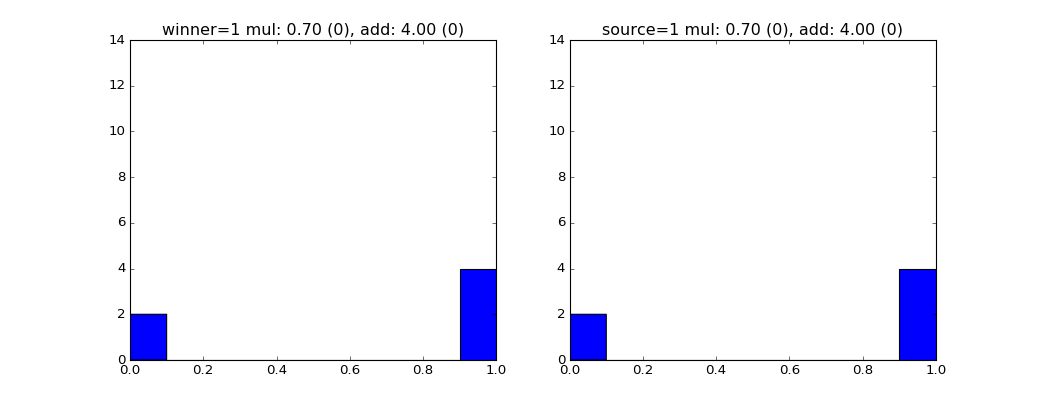

(0, 14)

In [7]:
o2src_time = get_o2src_time(obs_nodes, gvs)
r = sll_using_pairs(g,
                    obs_nodes,
                    infection_times=c,
                    o2src_time=o2src_time,
                    source=source,
                    method='dist', precond_method='and',
                    return_cascade=True)
sll, source, rs, pairs = r['sll'], r['source'], r['rs'], r['pairs']
addition_score = rs.sum(axis=0)

winner = np.argmax(sll)


y_max = max(np.histogram(rs[:, winner])[0].max(), np.histogram(rs[:, source])[0].max()) + 10
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].hist(rs[:, winner])
ax[0].set_title('winner={} mul: {:.2f} ({}), add: {:.2f} ({})'.format(
    winner, sll[winner], 
    get_rank_index(sll, winner),
    addition_score[winner],
    get_rank_index(addition_score, winner)))
ax[0].set_ylim(0, y_max)
ax[1].hist(rs[:, source])
ax[1].set_title('source={} mul: {:.2f} ({}), add: {:.2f} ({})'.format(
    source, sll[source], 
    get_rank_index(sll, source),
    addition_score[source],    
    get_rank_index(addition_score, source)))
ax[1].set_ylim(0, y_max)


In [ ]:
from scipy.stats import pearsonr

def corr_analysis_one_run(g, p, q, gvs):
    r = one_run(g, p, q, gvs, exact_cmp=False, return_cascade=True)
    infection_times = r['infection_times']
    rs = r['rs']
    source = r['source']
    pairs = r['pairs']

    time_pairs = np.array([(infection_times[o1], infection_times[o2]) for o1, o2 in pairs])

    # fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    min_corr = pearsonr(time_pairs.min(axis=1), rs[:, source])[0]
    max_corr = pearsonr(time_pairs.max(axis=1), rs[:, source])[0]
    mean_corr = pearsonr(time_pairs.mean(axis=1), rs[:, source])[0]
    return min_corr, max_corr, mean_corr

In [ ]:
corrs = Parallel(n_jobs=-1)(delayed(corr_analysis_one_run)(g, p, q, gvs) for i in range(16))


In [ ]:
corrs = np.array(corrs)
np.mean(corrs, axis=0)

In [ ]:
np.arr

In [ ]:
results = Parallel(n_jobs=-1)(delayed(one_run)(g, p, q, gvs, exact_cmp=False, eps=0.5) for i in range(16))
slls = np.array([r[0][r[1]] for r in results])

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(slls)

In [ ]:
pairs, rs[source]

In [ ]:
np.mean(counts_arr, axis=0)[source]

## time difference varies a lot even for source neighbors

when `p` is not large, the time difference between pairs can be quite diverse. 

the following code simulates `K` rounds and accumulates the time difference between a pair of source's neighbors

In [ ]:
source = random.choice(np.arange(g.num_vertices(), dtype=int))
m = []
for i in range(1000):
    _, infection_times = simulate_cascade(g, p, source=source)
    m.append(infection_times)
m = np.array(m, dtype=np.int32)

In [ ]:
# two neighbors
u, v = map(int, list(g.vertex(source).out_neighbours())[:2])
mask = np.logical_and(m[:, u] != -1, m[:, v] != -1)
print('#active simulations = {}'.format(np.sum(mask)))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(m[mask, u] - m[mask, v])
ax[0].set_title('time diff between source\' two nbrs')

dist = shortest_distance(g, source=source)
v = np.argsort(dist.a)[-1]
mask = np.logical_and(m[:, u] != -1, m[:, v] != -1)
print('#active simulations = {}'.format(np.sum(mask)))


ax[1].hist(m[mask, u] - m[mask, v])
ax[1].set_title('time diff between two furthest nodes to source')


## central question: why pair method fails when `q`=1?

  


### 1, the source gets a lot of zero-valued rewards

so multiplying the zeros (though padded with `epsilon`) together gives it low score.

the zero entries are produced especially by observed pairs that are in different "region" of the network.

this is because:

- IC model allows **exponential** number of infection configurations for the same source (just think how many possible subgraphs are there given there are `p|E|` edges (in expectation))
- in practice, simulation number is insufficient (`K` is small) so that there are almost always some simulation s.t. both nodes in the pair are uninfected

adding up together, there is a great chance that the observed cascade **does not match any** of the simulated cascades because the number of simulation rounds is far from exponential.

then the question is:

- **how to fight the sparsity issue**
  1. using different cascade `mask`, we can mitigate this issue. for example, by filtering cascades where at least one node is infected, we can get far more non-zeros
  2. based on the above, using infection time order as signal gives less zeros
  3. in general, we can incorporate smoothing parameter to make the signal non-zero

### 2, why nodes other than source gets higher rewards?


1. why?
2. who are these nodes?

## distance to source vs uncertainty of the time difference

Conclusion: 

- the further the node pairs to the source, the less uncertainty (low entropy) there is
- `dist_min` does not correlate much with uncertainty while `dist_max` has obvious correlation.

Further question:

- does this observation generalize to other `p` values and graph types?

For `kr-rand`, `er` and `barabasi`, this phenomenon is more obvious than `kr-hier`, `kr-peri`.

Does this mean, for certain graphs that demonstrate this phenomenon, we should:

- give more trust to further nodes.
- give less trust to nearer nodes



In [ ]:
from scipy.stats import entropy

In [ ]:
dist = shortest_distance(g)

In [ ]:
def distance_vs_entropy(g, p, source):
    m = []
    for i in range(1000):
        _, infection_times = simulate_cascade(g, p, source=source)
        m.append(infection_times)
    m = np.array(m, dtype=np.int32)
    entropies = {}
    valid_uvs = []
    for u, v in itertools.combinations(np.arange(g.num_vertices()), 2):
        mask = np.logical_and(m[:, u] != -1, m[:, v] != -1)
        diff = m[mask, u] - m[mask, v]
        if diff.shape[0] >0 :
            pk = np.bincount(diff-diff.min()) / diff.shape[0]
            entropies[(u, v)] = entropy(pk)
            valid_uvs.append((u, v))
    dist = shortest_distance(g, source=source)
    uvs = sorted(valid_uvs, key=entropies.__getitem__)  # low to high entropy
    x = [entropies[(u, v)] for u, v in uvs]
    y_min = [min(dist.a[u], dist.a[v]) for u, v in uvs]
    y_max = [max(dist.a[u], dist.a[v]) for u, v in uvs]
    y_avg = [(dist.a[u] + dist.a[v]) /2 for u, v in uvs]
    
    dist2d = shortest_distance(g)
    y_pair = [dist2d[u][v] for u, v in uvs]
    return pearsonr(x, y_min)[0], pearsonr(x, y_max)[0], pearsonr(x, y_avg)[0],  pearsonr(x, y_pair)[0]


def corr_stat_with_uncertainty(gtype):
    g = load_graph('data/{}/{}/graph.gt'.format(gtype, param))
    source = random.choice(np.arange(g.num_vertices(), dtype=int))
    ps = np.linspace(0.1, 0.9, 9)
    mma_corrs = np.array([distance_vs_entropy(g, p, source)
                          for p in ps])
    df = pd.DataFrame(mma_corrs, columns=['dist_min', 'dist_max', 'dist_avg', 'dist_pair'], index=ps)
    return gtype, df

In [ ]:
gndf = Parallel(n_jobs=-1)(delayed(corr_stat_with_uncertainty)(gtype)
                           for gtype in tqdm(['kr-rand', 'kr-hier', 'kr-peri', 'barabasi', 'er']))

gndf = {gtype: df for gtype, df in gndf}

In [ ]:
gndf['er']

## using absolute time

it's trivial to infer that the source is closer to nodes that are earlier infected than nodes that are later infected.

also, from current observation, we know the **upper bound** on the source's infection time.

given a node `u` and the upper bound of `t(s)`, we can:

1. run reverse simulation starting from `u`
2. collect all the nodes that are at least `t(u) - t(s)` from `u` on the sampled graph

the resulting node sets are possible candidates.

## what's next

- **measurement**:  source's rank by the weight (in contrast to the actual value)
- **pair methods and different masks**:
  - `exact`: `None` | `and`
  - `order`: `and` | `or`
  - `dist`: `and`
  - in total: 5 configurations
- **effect of `eps`**: the smoothing parameter